# Проект: классификация

In [366]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV #Grid Search
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import classification_report
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.tree import DecisionTreeRegressor
import optuna

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [279]:
df = pd.read_csv('Data/bank_fin.csv', sep = ';')

In [280]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


### Задание 2

In [281]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

### Задание 3

In [282]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].apply(lambda x: str(x).replace(" ", "").replace("$", "").replace(",", ".")).astype(float)
# вычислим среднее значение:
round(df['balance'].mean(),3)

1529.129

### Задание 4

In [283]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance']=df['balance'].fillna(df['balance'].median())
round(df['balance'].mean(),3)

1526.936

### Задание 5

In [284]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df['job']=df['job'].replace('unknown', df['job'].mode()[0])
df['education']=df['education'].replace('unknown', df['education'].mode()[0])
round(df[(df['job'] == df['job'].mode()[0]) & (df['education'] == df['education'].mode()[0])]['balance'].mean(),3)

1598.883

### Задание 6

In [285]:
# удалите все выбросы для признака balance

# метод Тьюки
quartile_1, quartile_3 = df['balance'].quantile(0.25), df['balance'].quantile(0.75),
iqr = quartile_3 - quartile_1
lower_bound = quartile_1 - (iqr * 1.5)
upper_bound = quartile_3 + (iqr * 1.5)
print(lower_bound,upper_bound)

outliers = df[(df['balance']<lower_bound) | (df['balance'] > upper_bound)]
df = df[(df['balance']>=lower_bound) & (df['balance'] <= upper_bound)]

print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {df.shape[0]}')

-2241.0 4063.0
Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

In [286]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# Сколько клиентов открыли депозит?
df['deposit'].value_counts()

no     5424
yes    4681
Name: deposit, dtype: int64

### Задания 2 и 3

In [287]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


### Задания 4 и 5

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


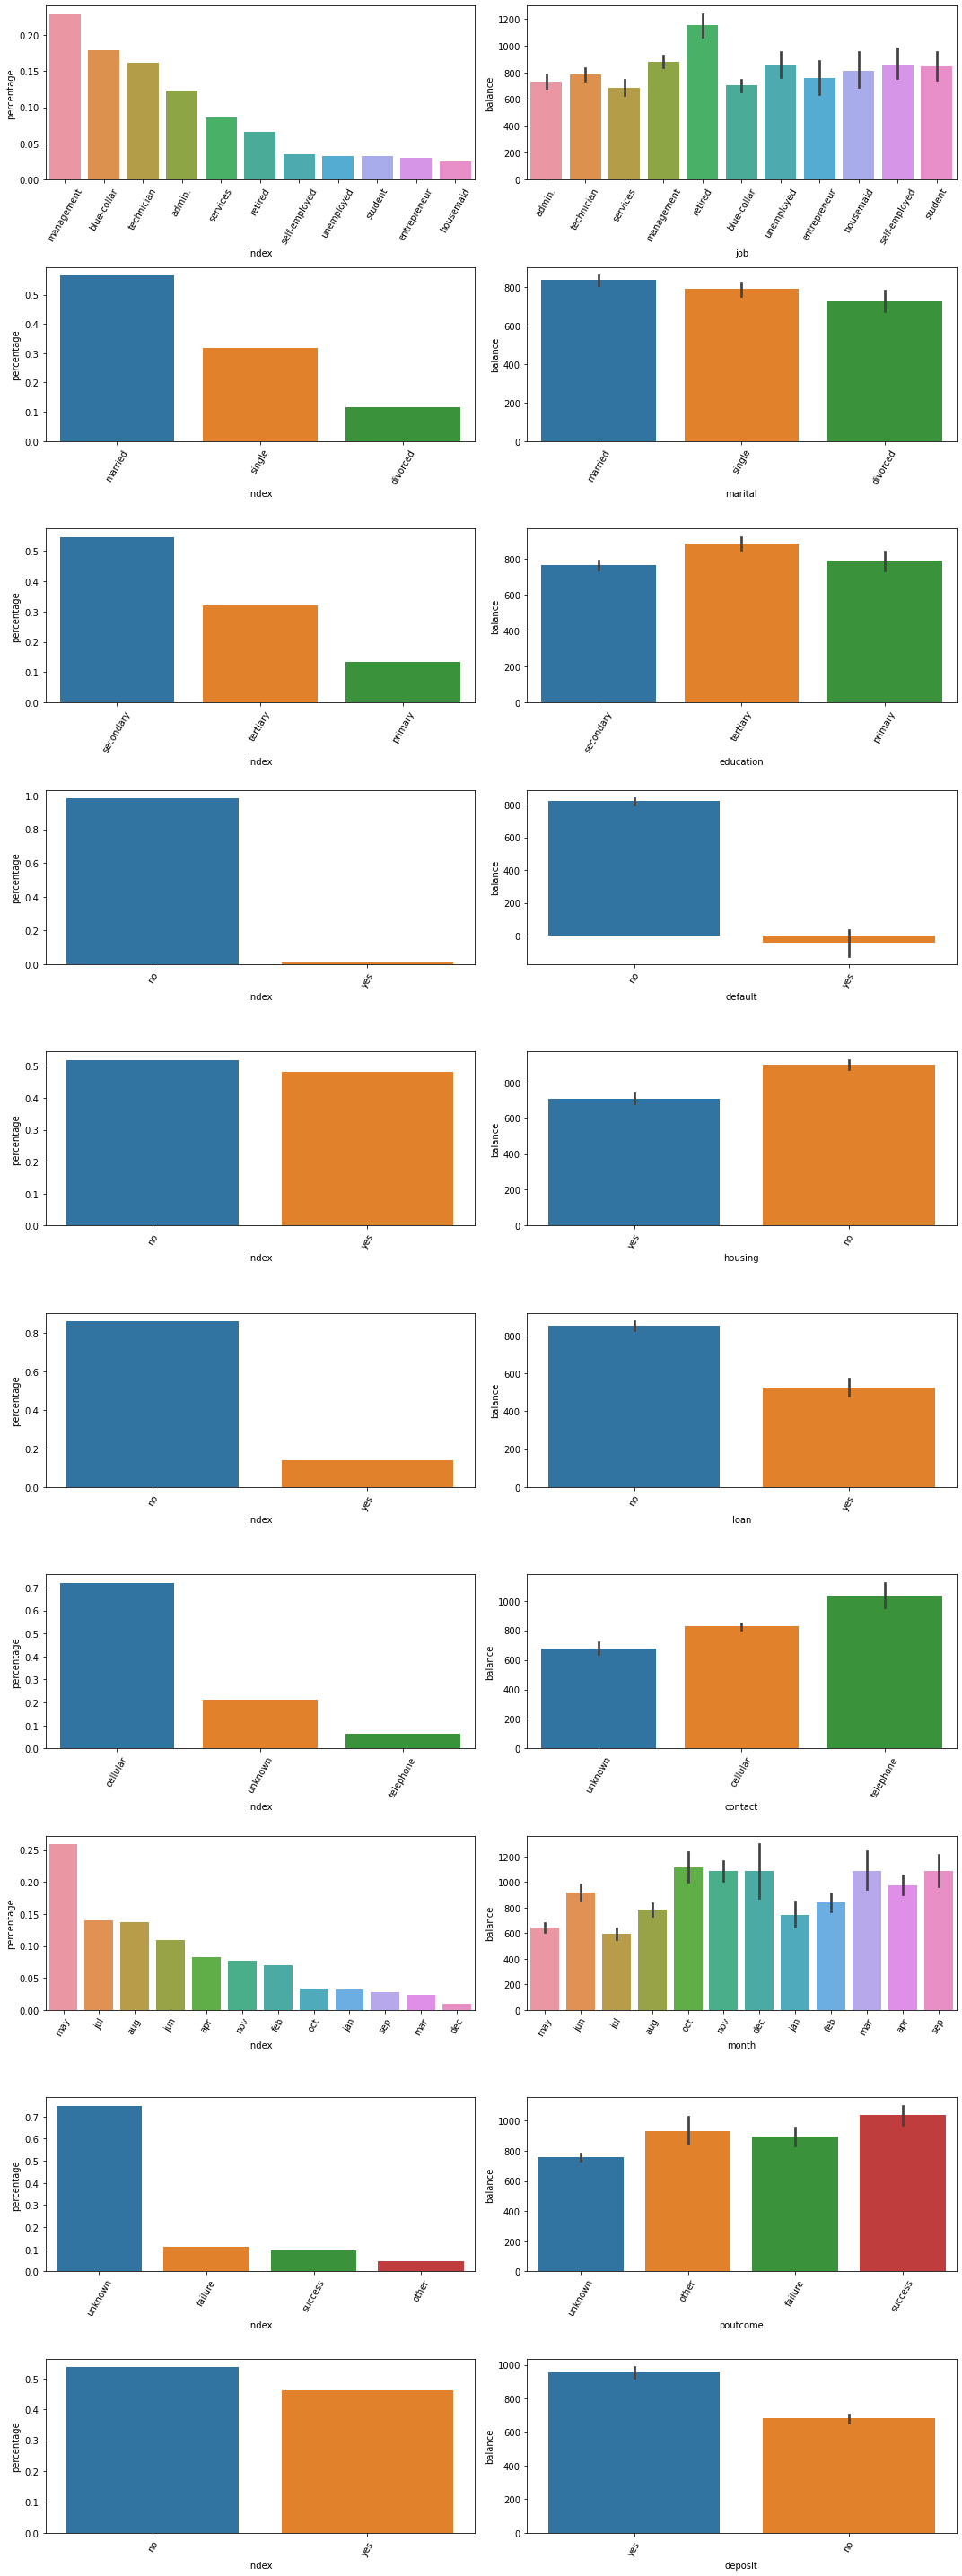

In [288]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
display(df.describe(include = 'object'))

#постройте визуализации, иллюстрирующие результаты
types = df.dtypes
cat_features = list(types[(types == 'object')].index)

n = len(cat_features) #число категориальных признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) #фигура+n*2 координатных плоскостей
#Создаем цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    #Строим количественную столбчатую для долевого соотношения каждой из категорий в данных
    count_data = (df[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x='index', y='percentage', ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    #Строим столбчатую диаграмму зависимости от категории
    mean_barplot = sns.barplot(data=df, x=feature, y='balance', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout() #выравнивание графиков

### Задание 6

In [289]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
round(df.groupby('poutcome')['deposit'].value_counts(normalize=True)*100,0)

poutcome  deposit
failure   no         51.0
          yes        49.0
other     yes        55.0
          no         45.0
success   yes        91.0
          no          9.0
unknown   no         60.0
          yes        40.0
Name: deposit, dtype: float64

### Задание 7

In [290]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
round(df.groupby('month')['deposit'].value_counts(normalize=True)*100,0)

month  deposit
apr    yes        62.0
       no         38.0
aug    no         56.0
       yes        44.0
dec    yes        90.0
       no         10.0
feb    yes        54.0
       no         46.0
jan    no         61.0
       yes        39.0
jul    no         59.0
       yes        41.0
jun    no         55.0
       yes        45.0
mar    yes        90.0
       no         10.0
may    no         68.0
       yes        32.0
nov    no         58.0
       yes        42.0
oct    yes        81.0
       no         19.0
sep    yes        83.0
       no         17.0
Name: deposit, dtype: float64

### Задание 8

age_group  deposit
30-40      no         57.0
           yes        43.0
40-50      no         61.0
           yes        39.0
50-60      no         59.0
           yes        41.0
60+        yes        76.0
           no         24.0
<30        yes        59.0
           no         41.0
Name: deposit, dtype: float64

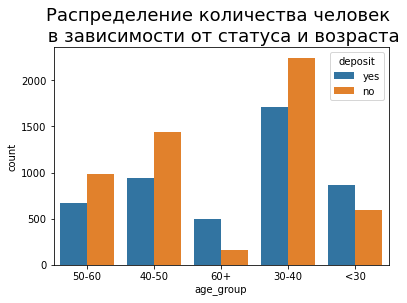

In [291]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

def age_group(age):
    if age<30: return '<30'
    if age<40: return '30-40'
    if age<50: return '40-50'
    if age<60: return '50-60'
    if age<30: return '<30'
    else: return '60+'
    
df['age_group'] = df['age'].apply(age_group)
display(round(df.groupby('age_group')['deposit'].value_counts(normalize=True)*100,0))

# визуализация
countplot = sns.countplot(data=df, x="age_group", hue="deposit");
countplot.set_title('Распределение количества человек \n в зависимости от статуса и возраста', fontsize=18);

### Задания 9 и 10

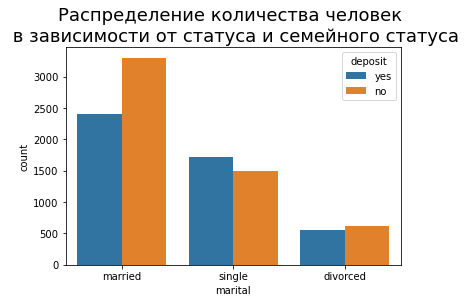

In [292]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

countplot = sns.countplot(data=df, x="marital", hue="deposit");
countplot.set_title('Распределение количества человек \n в зависимости от статуса и семейного статуса', fontsize=18);

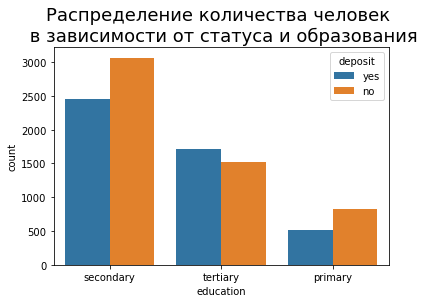

In [293]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

countplot = sns.countplot(data=df, x="education", hue="deposit");
countplot.set_title('Распределение количества человек \n в зависимости от статуса и образования', fontsize=18);

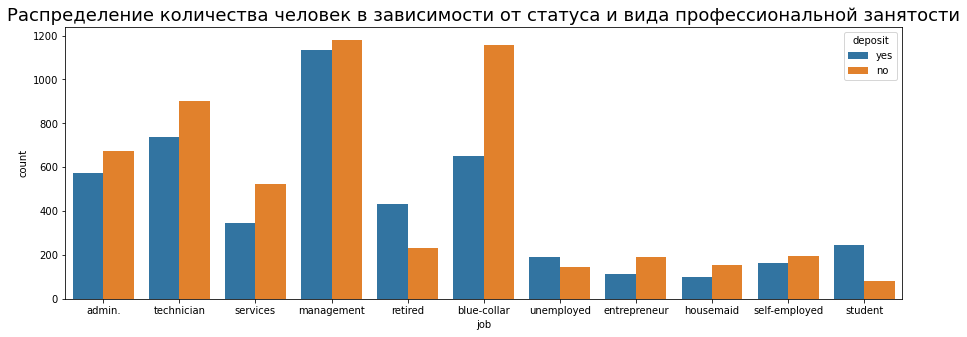

In [294]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

fig = plt.figure(figsize=(15, 5))
countplot = sns.countplot(data=df, x="job", hue="deposit");countplot.set_title('Распределение количества человек в зависимости от статуса и вида профессиональной занятости', fontsize=18);


### Задание 11

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


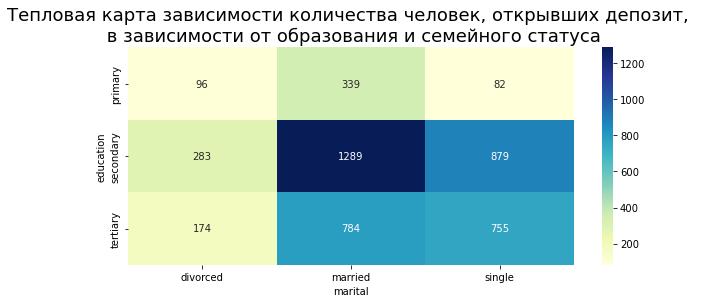

In [295]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
# Строим сводную таблицу
df_pivot = df[df['deposit'] == 'yes'].pivot_table(
    values = 'deposit',
    index = 'education',
    columns = 'marital',
    aggfunc='count',
    )
display(df_pivot)


# Тепловая карта
fig = plt.figure(figsize=(10, 4))
heatmap = sns.heatmap(data=df_pivot, cmap='YlGnBu', annot=True, fmt="d")
heatmap.set_title('Тепловая карта зависимости количества человек, открывших депозит, \n в зависимости от образования и семейного статуса', fontsize=18);

## Часть 3: преобразование данных

### Задание 1

In [296]:
# преобразуйте уровни образования
# Начнём с обработки категориального порядкового признака, который отвечает за уровень образования: education.
# Обработайте его с помощью метода LabelEncoder, используя метод без дополнительных настроек.
# Найдите сумму получившихся значений для признака education

LE=LabelEncoder()
df['education'] = LE.fit_transform(df['education'])
display(df['education'].sum())

# Ранее мы создали порядковую переменную для возраста. 
# Обработайте её по такому же принципу, чтобы её можно было использовать при обучении модели.
df['age_group'] = LE.fit_transform(df['age_group'])

11995

### Задания 2 и 3

In [297]:
# преобразуйте бинарные переменные в представление из нулей и единиц

display(df.describe(include=object))
binary_cols = ('deposit', 'default', 'housing', 'loan')
for col in binary_cols:
    df[col] = df[col].apply(lambda x: 1 if x == 'yes' else 0)

round(df.describe(),3)

,job,marital,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,2,2,2,3,12,4,2
top,management,married,no,no,no,cellular,may,unknown,no
freq,2315,5715,9939,5243,8712,7283,2617,7570,5424


,age,education,default,balance,housing,loan,day,duration,campaign,pdays,previous,deposit,age_group
count,10105.000,10105.000,10105.000,10105.000,10105.000,10105.000,10105.000,10105.000,10105.000,10105.000,10105.000,10105.000,10105.000
mean,40.895,1.187,0.016,807.654,0.481,0.138,15.590,368.743,2.517,51.320,0.816,0.463,1.333
std,11.735,0.647,0.127,994.152,0.500,0.345,8.442,346.652,2.707,109.644,2.244,0.499,1.414
min,18.000,0.000,0.000,-2049.000,0.000,0.000,1.000,2.000,1.000,-1.000,0.000,0.000,0.000
25%,32.000,1.000,0.000,95.000,0.000,0.000,8.000,137.000,1.000,-1.000,0.000,0.000,0.000
50%,38.000,1.000,0.000,445.000,0.000,0.000,15.000,252.000,2.000,-1.000,0.000,0.000,1.000
75%,48.000,2.000,0.000,1227.000,1.000,0.000,22.000,490.000,3.000,2.000,1.000,1.000,2.000
max,95.000,2.000,1.000,4063.000,1.000,1.000,31.000,3881.000,43.000,854.000,58.000,1.000,4.000


### Задание 4

In [298]:
# создайте дамми-переменные
# Сколько теперь всего признаков в датасете, не считая целевую переменную? 
# Введите ответ, посчитав уже добавленные dummy-переменные, но до удаления номинальных.

df = pd.get_dummies(df,drop_first=True)
df.shape[1]+9

50

### Задания 5 и 6

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
age,1.000000,-0.191124,-0.009929,0.115164,-0.164196,-0.026357,0.000396,-0.006007,-0.001143,0.006107,...,-0.003662,0.009769,0.024785,-0.119656,0.026875,0.056998,0.036352,-0.020942,0.060009,-0.031455
education,-0.191124,1.000000,-0.015692,0.043251,-0.094350,-0.052566,0.008989,-0.016869,-0.012280,0.024123,...,-0.049832,-0.036503,0.052196,-0.104157,0.028704,0.027617,0.030846,0.015103,0.070489,-0.069069
default,-0.009929,-0.015692,1.000000,-0.110928,0.009551,0.074786,0.018724,-0.008162,0.033404,-0.037323,...,0.048653,0.019626,-0.020028,-0.001761,0.000544,-0.023931,-0.016977,-0.017923,-0.041510,0.055032
balance,0.115164,0.043251,-0.110928,1.000000,-0.094919,-0.113089,-0.009987,0.025781,-0.042689,0.045155,...,-0.086824,0.039753,0.043832,-0.098073,0.081861,0.057041,0.047841,0.028111,0.073358,-0.085456
housing,-0.164196,-0.094350,0.009551,-0.094919,1.000000,0.072252,-0.022644,0.038492,0.006257,0.064138,...,-0.029806,-0.073133,-0.075948,0.432605,-0.000219,-0.092026,-0.086893,0.009830,-0.134477,0.024082
loan,-0.026357,-0.052566,0.074786,-0.113089,0.072252,1.000000,0.019136,0.001476,0.033889,-0.030788,...,0.163249,-0.014897,-0.041105,0.002778,0.017720,-0.032357,-0.046196,-0.019289,-0.082098,0.059235
day,0.000396,0.008989,0.018724,-0.009987,-0.022644,0.019136,1.000000,-0.016695,0.142169,-0.078757,...,0.130897,-0.182032,-0.044303,-0.014580,0.056471,0.072179,-0.068744,-0.008806,-0.044366,0.085442
duration,-0.006007,-0.016869,-0.008162,0.025781,0.038492,0.001476,-0.016695,1.000000,-0.042576,-0.033053,...,0.056203,-0.003061,-0.034640,0.007983,-0.015655,-0.012541,-0.012077,-0.009497,-0.025971,0.050571
campaign,-0.001143,-0.012280,0.033404,-0.042689,0.006257,0.033889,0.142169,-0.042576,1.000000,-0.105214,...,0.118163,0.046763,-0.030574,-0.044348,-0.077307,-0.071519,-0.048672,-0.024854,-0.094260,0.134842
pdays,0.006107,0.024123,-0.037323,0.045155,0.064138,-0.030788,-0.078757,-0.033053,-0.105214,1.000000,...,-0.108347,-0.093551,0.024192,0.028678,-0.007350,0.079833,0.110907,0.338049,0.326215,-0.824031


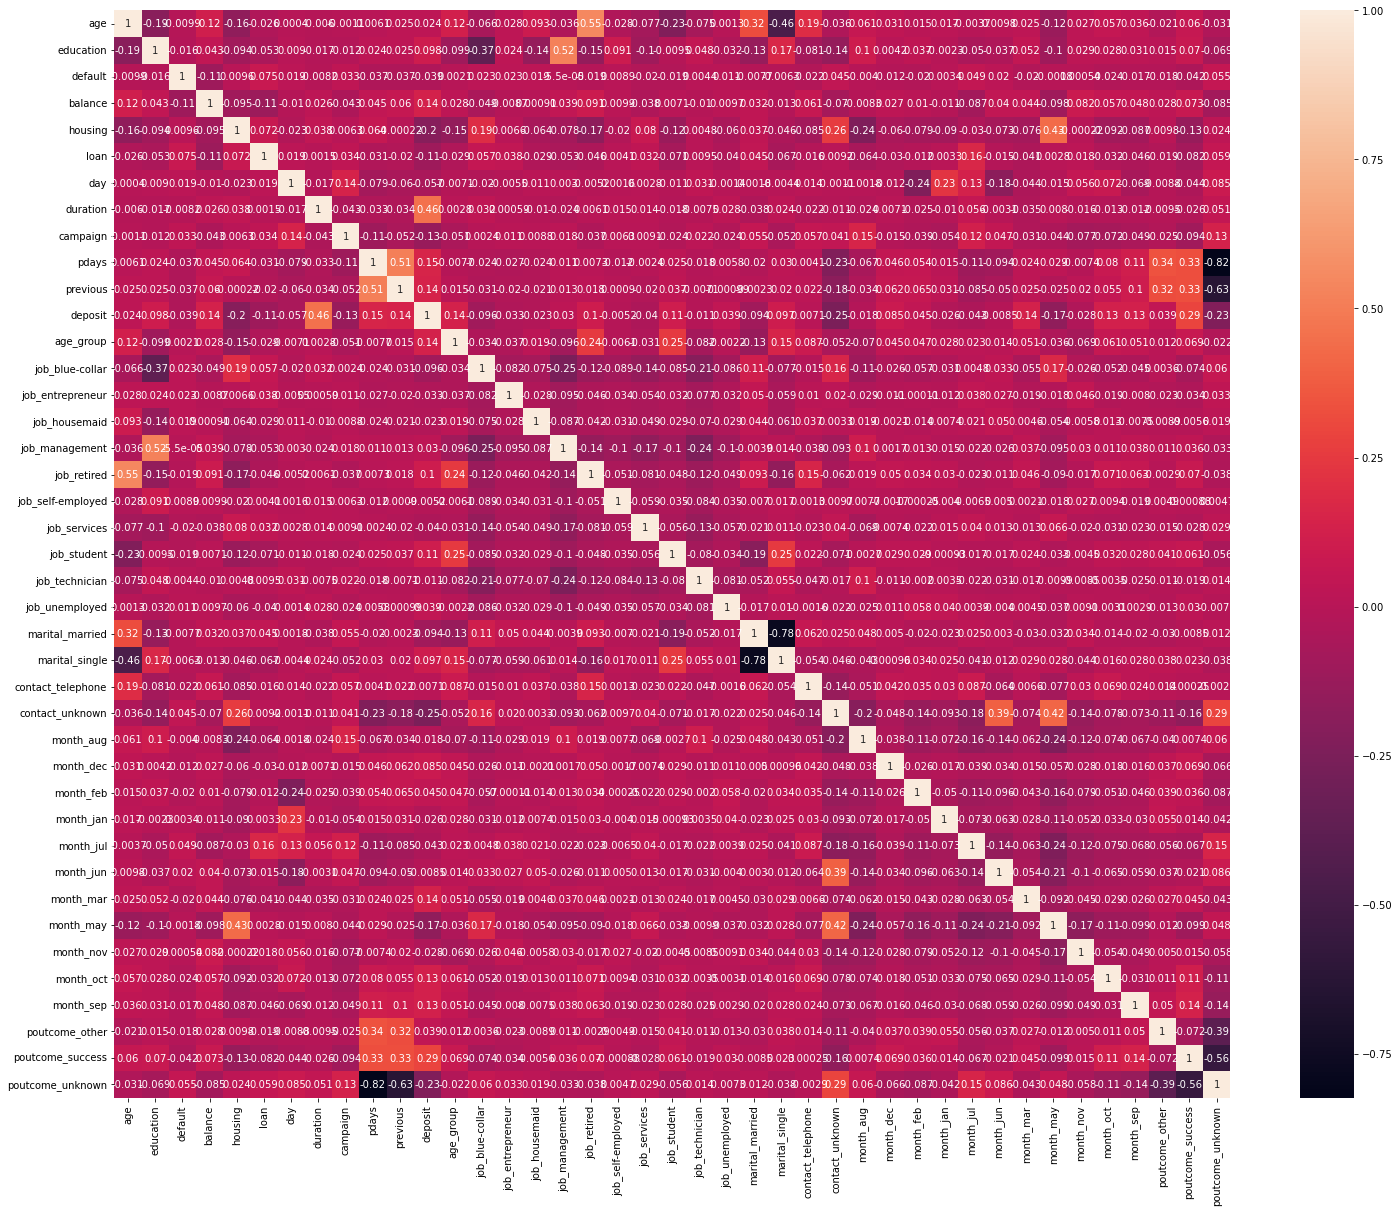

In [299]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
display(df.corr())
plt.figure(figsize = (25, 20))
sns.heatmap(df.corr(), annot = True);

### Задания 7 и 8

In [300]:
# Теперь вам необходимо определить целевую переменную и предикторы, а также разделить выборку на обучающую и тестовую.
# При разбиении задайте параметр random_state = 42, а размер тестовой выборки возьмите за 0.33. 
# Не забудьте добавить аргумент, определяющий сохранение соотношений целевого признака.

X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [301]:
# рассчитайте необходимые показатели
# Каким получился размер тестовой выборки?
display(X_test.shape[0])

# Каково среднее значение целевой переменной на тестовой выборке? 
# Ответ округлите до двух знаков после точки-разделителя.
round(y_test.mean(),2)

3335

0.46

### Задание 9

In [302]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

array(['balance', 'housing', 'loan', 'duration', 'campaign', 'pdays',
       'previous', 'age_group', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

### Задание 10

In [303]:
# нормализуйте данные с помощью minmaxsxaler

scaler = preprocessing.MinMaxScaler()
cols = X_train.columns
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=cols)
X_test = pd.DataFrame(scaler.transform(X_test), columns=cols)

# Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из тестовой выборки. 
# Ответ округлите до двух знаков после точки-разделителя.
round(X_test['balance'].mean(),2)

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [305]:
# обучите логистическую регрессию и рассчитайте метрики качества
# Для начала реализуем самый простой алгоритм, который вам известен — логистическую регрессию. 
# В качестве алгоритма оптимизации будем использовать 'sag', в качестве значения параметра random_state 
# возьмём число 42 и запустим 1000 итераций.

# Для получившейся модели вычислите значение accuracy на тестовой выборке. 
# Ответ округлите до двух знаков после точки-разделителя.

#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(solver='sag', max_iter = 1000, random_state=42)
#Обучаем модель
log_reg.fit(X_train, y_train)
y_test_pred = log_reg.predict(X_test)
print("accuracy на тестовом наборе: {:.2f}".format(log_reg.score(X_test, y_test)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.82
f1_score на тестовом наборе: 0.80


### Задания 2,3,4

In [324]:
# обучите решающие деревья, настройте максимальную глубину

# Теперь давайте обучим ещё один алгоритм — решающие деревья. В качестве параметров для начала возьмём следующие:
# criterion = 'entropy';
# random_state = 42.
# Остальные параметры оставьте по умолчанию.

# Переберите различные максимальные глубины деревьев и найдите глубину дерева, для которой будет максимальное значение 
# метрики accuracy, но при этом ещё не будет наблюдаться переобучения (т. е. не будет расти качество на обучающей 
# выборке при неизменном качестве на тестовой).

param_grid = {'max_depth': list(np.linspace(1, 7, 7, dtype=int))},
            
grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(criterion='entropy', random_state=42),
    param_grid=param_grid, 
    cv=5, # количество фолдов в кросс-валидации, по умолчанию используется 5.
    n_jobs = -1 # количество ядер для распараллеливания расчёта. -1 использует все существующие ядра.
)  
grid_search.fit(X_train, y_train) 
y_test_pred = grid_search.predict(X_test)

print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

accuracy на тестовом наборе: 0.81
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 6}


### Задание 5

In [326]:
# подберите оптимальные параметры с помощью gridsearch
# Реализуйте оптимизацию гиперпараметров с помощью GridSearch, перебрав следующие параметры:
# 'min_samples_split': [2, 5, 7, 10];
# 'max_depth':[3,5,7].

# Оцените метрику \(F_{1}\) на тестовой выборке для наилучшей комбинации перебираемых параметров. 
# В качестве ответа впишите значение метрики. Ответ округлите до двух знаков после точки-разделителя.

param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth':[3,5,7]},
            
grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=7),
    param_grid=param_grid, 
    cv=5, # количество фолдов в кросс-валидации, по умолчанию используется 5.
    n_jobs = -1 # количество ядер для распараллеливания расчёта. -1 использует все существующие ядра.
)  
grid_search.fit(X_train, y_train) 
y_test_pred = grid_search.predict(X_test)

print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 7}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [328]:
# обучите на ваших данных случайный лес

# Обучите случайный лес со следующими параметрами:
# n_estimators = 100;
# criterion = 'gini';
# min_samples_leaf = 5;
# max_depth = 10;
# random_state = 42.

# Оцените метрики accuracy и recall для построенной модели на тестовой выборке. В качестве ответов введите 
# значения метрик. Ответ округлите до двух знаков после точки-разделителя.


#Создаем объект класса random forest
rf = ensemble.RandomForestClassifier(n_estimators = 100, criterion = 'gini', min_samples_leaf = 5, max_depth = 10, random_state = 42)
#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
print("accuracy на тестовом наборе: {:.2f}".format(log_reg.score(X_test, y_test_pred)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

#Выводим значения метрик
print(metrics.classification_report(y_test, y_test_pred)) 

accuracy на тестовом наборе: 0.90
f1_score на тестовом наборе: 0.83
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      1790
           1       0.80      0.85      0.83      1545

    accuracy                           0.84      3335
   macro avg       0.84      0.84      0.84      3335
weighted avg       0.84      0.84      0.84      3335



### Задания 2 и 3

In [335]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

# Используйте градиентный бустинг для решения задачи классификации, задав для него следующие параметры:
# learning_rate = 0.05;
# n_estimators = 300;
# min_samples_leaf = 5;
# max_depth = 5;
# random_state = 42.

# Для построенной модели оцените метрику \(F_{1}\) на тестовой выборке. 
# В качестве ответа впишите значение метрики. Ответ округлите до двух знаков после точки-разделителя.


gb = ensemble.GradientBoostingClassifier(
        learning_rate = 0.05,
        n_estimators = 300,
        min_samples_leaf = 5,
        max_depth = 5,
        random_state = 42
)
gb.fit(X_train, y_train)

y_test_pred = gb.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.85


### Задание 4

In [363]:
# объедините уже известные вам алгоритмы с помощью стекинга: 
# решающие деревья, логистическую регрессию и градиентный бустинг. 
# В качестве метамодели используйте модель логистической регрессии.
# Параметры оставьте те же, что были в ваших алгоритмах в предыдущих заданиях.

# Для построенной модели оцените метрику precision на тестовой выборке. 
# В качестве ответа впишите значение метрики. Ответ округлите до двух знаков после точки-разделителя.

#Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('dt', DecisionTreeRegressor(
        #criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', RidgeCV(
        #solver='sag',
        #random_state=42 
        )
    ),
    ('gb', ensemble.GradientBoostingRegressor(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

#Создаем объект класса стекинг
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RidgeCV()#random_state=42)
)
#Обучаем модель
reg.fit(X_train, y_train)

y_test_pred = reg.predict(X_test)

print(f'Качество предсказания {round(metrics.precision_score(y_test, y_test_pred),2)}')

#Выводим значения метрик
print(classification_report(y_test, y_test_pred))

ValueError: Classification metrics can't handle a mix of binary and continuous targets

### Задание 5

In [ ]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [367]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
# Для перебора возьмите случайный лес и следующие параметры:
# n_estimators = trial.suggest_int('n_estimators', 100, 200, 1);
# max_depth = trial.suggest_int('max_depth', 10, 30, 1);
# min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1).

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=50)

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

[I 2022-10-05 15:16:14,679] A new study created in memory with name: RandomForestClassifier
[I 2022-10-05 15:16:15,231] Trial 0 finished with value: 0.9283372365339578 and parameters: {'n_estimators': 102, 'max_depth': 21, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9283372365339578.
[I 2022-10-05 15:16:15,863] Trial 1 finished with value: 0.8669674809397853 and parameters: {'n_estimators': 141, 'max_depth': 13, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.9283372365339578.
[I 2022-10-05 15:16:16,616] Trial 2 finished with value: 0.9284603421461898 and parameters: {'n_estimators': 144, 'max_depth': 26, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9284603421461898.
[I 2022-10-05 15:16:17,145] Trial 3 finished with value: 0.92601802921977 and parameters: {'n_estimators': 101, 'max_depth': 24, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9284603421461898.
[I 2022-10-05 15:16:18,027] Trial 4 finished with value: 0.8728056667693255 and parameters: {'n_e

accuracy на тестовом наборе: 0.85
f1_score на тестовом наборе: 0.84
